In [1]:
import json
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from ase import Atoms
from phonopy import Phonopy

from utils import inscribed_sphere_in_box

In [3]:
ds = xr.load_dataset('md/trajectory.nc')

In [4]:
from hiphive import ClusterSpace, StructureContainer, ForceConstantPotential
from hiphive.fitting import Optimizer
from hiphive.calculators import ForceConstantCalculator

In [5]:
ds

<xarray.Dataset>
Dimensions:           (I: 120, a: 3, b: 3, time: 2001)
Coordinates:
  * time              (time) float64 0.0 5.0 10.0 ... 9.99e+03 9.995e+03 1e+04
Dimensions without coordinates: I, a, b
Data variables:
    positions         (time, I, a) float64 0.0 0.0 0.0 ... 6.197 -2.106 8.314
    displacements     (time, I, a) float64 0.0 0.0 0.0 ... -0.0235 -0.01749
    velocities        (time, I, a) float64 0.0 0.0 0.0 ... -0.01277 0.02673
    momenta           (time, I, a) float64 0.0 0.0 0.0 ... 0.5365 -0.2043 0.4277
    forces            (time, I, a) float64 -2.969e-07 4.388e-06 ... 0.04982
    kinetic_energy    (time) float64 0.0 0.1299 0.2174 ... 4.31 4.41 4.271
    potential_energy  (time) float64 -1.568e+07 -1.568e+07 ... -1.568e+07
    stress            (time, a, b) float64 -1.188e-05 -9.125e-08 ... -0.006106
    pressure          (time) float64 8.103e-06 1.379e-05 nan ... nan 0.004405
    temperature       (time) float64 0.0 8.377 14.01 17.45 ... 277.9 284.3 275.4
Attrib

In [6]:
primitive = Atoms(**json.loads(ds.attrs["reference primitive atoms"]))
supercell = Atoms(**json.loads(ds.attrs["reference atoms"]))

supercell_matrix = (supercell.cell @ primitive.get_reciprocal_cell()).round().astype(int)
supercell_matrix

array([[ 2, -2,  0],
       [ 2,  2,  0],
       [ 0,  0,  3]])

In [7]:
max_cutoff = inscribed_sphere_in_box(supercell.cell)

cutoffs = [.99 * max_cutoff]

In [8]:
max_cutoff, supercell.cell[0, 0] / 2

(5.891198162475282, 4.16570617)

In [9]:
cs = ClusterSpace(supercell, cutoffs=cutoffs)

Primitive cell:
    Formula: BaHfO3
    Cell:
        [  4.16571   0.00000   0.00000]
        [  0.00000   4.16571   0.00000]
        [  0.00000   0.00000   4.16571]
    Basis:
        Ba  [  0.00000   0.00000   0.00000]
        Hf  [  0.50000   0.50000   0.50000]
        O   [  0.00000   0.50000   0.50000]
        ...

Crystal symmetry:
    Spacegroup:          Pm-3m (221)
    Unique atoms:        3
    Symmetry operations: 48
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 5.832286180850529
    Found 5 center atoms with 92 images totaling 97 atoms

Clusters:
    Clusters: {2: 245}
    Total number of clusters: 245

Orbits:
    Orbits: {2: 14}
    Total number of orbits: 14

Eigentensors:
    Eigentensors: {2: 40}
    Total number of parameters: 40

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 36}
    Total number of degrees of freedom: 36


In [10]:
print(cs)

=================== Cluster Space ====================
Spacegroup                 : Pm-3m (221)
symprec                    : 1e-05
Sum rules                  : True
Length scale               : 0.1
Cutoffs                    :
====== Cutoffs =======
 body/order |    2    
----------------------
     1      |    -    
     2      | 5.83229 
Cell                       : Cell([4.16570617, 4.16570617, 4.16570617])
Basis                      :
[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [0.  0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0. ]]
Numbers                    : [56 72  8  8  8]
Total number of orbits     : 14
Total number of clusters   : 130
Total number of parameters : 36
------------------------------------------------------
order | n_orbits | n_clusters
------------------------------------------------------
  2   |     14   |     130


In [11]:
def get_fit_structures(reference_atoms, dataset, stride=100):
    """get the fit structures from the  dataset using samples separated by STRIDE"""

    fit_structures = []
    atoms_ideal = reference_atoms.copy()

    forces = dataset.forces.data[::stride]
    displacements = dataset.displacements.data[::stride]

    for f, d in zip(forces, displacements):
        structure = atoms_ideal.copy()
        structure.arrays["forces"] = f
        structure.arrays["displacements"] = d

        structure.positions = atoms_ideal.positions
        fit_structures.append(structure)
        
    return fit_structures

In [12]:
fit_structures = get_fit_structures(supercell, ds)

sc = StructureContainer(cs)

sc.delete_all_structures()
for ii, s in enumerate(fit_structures):
    print(f"\nAdd structure {ii:4d} / {len(fit_structures)}")
    sc.add_structure(s)


Add structure    0 / 21
Adding structure
Computing fit matrix
  Building new FCM object
Populating orbits
Done in 0d 0h 0m 3.99s
Done in 0d 0h 0m 6.2s

Add structure    1 / 21
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0522s

Add structure    2 / 21
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0609s

Add structure    3 / 21
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0542s

Add structure    4 / 21
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0583s

Add structure    5 / 21
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0485s

Add structure    6 / 21
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0424s

Add structure    7 / 21
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0507s

Add structure    8 / 21
Adding structure
Computing fit m

In [13]:
print(sc)

=============== Structure Container ================
Total number of structures : 21
----------------------------------------------------
index | num-atoms | avg-disp | avg-force | max-force
----------------------------------------------------
 0    |    120    |  0.0000  |   0.0000  |   0.0001 
 1    |    120    |  0.1187  |   0.8036  |   1.9533 
 2    |    120    |  0.1158  |   0.8903  |   3.7518 
 3    |    120    |  0.1217  |   0.8202  |   2.3313 
 4    |    120    |  0.1143  |   0.8785  |   2.4495 
 5    |    120    |  0.1241  |   0.8484  |   2.5047 
 6    |    120    |  0.1272  |   0.8030  |   2.8194 
 7    |    120    |  0.1283  |   0.8786  |   2.1414 
 8    |    120    |  0.1155  |   0.8408  |   2.9477 
 9    |    120    |  0.1183  |   0.8032  |   2.0027 
 10   |    120    |  0.1277  |   0.8781  |   2.1795 
 11   |    120    |  0.1152  |   0.8529  |   1.9563 
 12   |    120    |  0.1189  |   0.8939  |   2.7827 
 13   |    120    |  0.1194  |   0.8607  |   1.9672 
 14   |    120

In [14]:
opt = Optimizer(sc.get_fit_data())
opt.train()
print(opt)

===================== Optimizer ======================
fit_method                     : least-squares
n_nonzero_parameters           : 36
n_parameters                   : 36
n_target_values                : 7560
parameters_norm                : 9.039693
rmse_test                      : 0.1299806
rmse_train                     : 0.1269541
seed                           : 42
standardize                    : True
target_values_std              : 0.5370555
test_size                      : 1890
train_size                     : 5670


In [15]:
fcp = ForceConstantPotential(cs, opt.parameters)

fcs = fcp.get_force_constants(supercell)

Populating orbits
Done in 0d 0h 0m 3.75s


In [16]:
phonon = Phonopy(primitive, supercell_matrix=supercell_matrix.T)

phonon.set_force_constants(fcs.get_fc_array(2))

In [17]:
primitive.cell.bandpath().path

'GXMGRX,MR'

In [18]:
bandpath = primitive.cell.bandpath(npoints=100, path="GXMGRX")

x, xticks, xticklabels = bandpath.get_linear_kpoint_axis()

In [19]:
phonon.run_band_structure([bandpath.kpts])

[Text(0, 0, 'G'),
 Text(0, 0, 'X'),
 Text(0, 0, 'M'),
 Text(0, 0, 'G'),
 Text(0, 0, 'R'),
 Text(0, 0, 'X')]

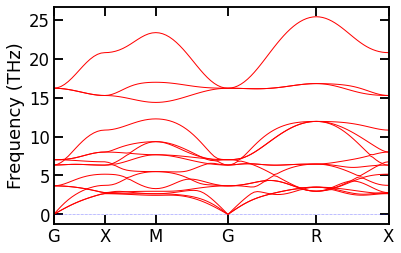

In [20]:
fig, ax = plt.subplots()

phonon.band_structure.plot([ax])

ax.set_xticks(xticks * ax.get_xlim()[1] / xticks.max())
ax.set_xticklabels(xticklabels)